# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [1]:
import matplotlib.pyplot as plt
import findspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
findspark.init()

sc = SparkContext

spark = SparkSession \
    .builder \
    .appName("Amazon Sentiment Analysis") \
    .getOrCreate()

dataframe = spark.read.json("./assets/Software_5.json")

print(dataframe.printSchema())
print("Data read", dataframe.count())
print(dataframe.describe())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

None
Data read 12805
DataFrame[summary: string, asin: string, overall: string, reviewText: string, reviewTime: string, reviewerID: string, reviewerName:

The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote.

Also, note that the data type of `vote` is `object`. But since vote can only be a number, we want to convert vote to `int64` data type

Now after preprocessing the vote, we can see that the data type of vote is `int64`

In [2]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType

df = dataframe.dropna(how="any", subset=["vote", "overall", "reviewText"])
# Some vote has , in number, we just need to remove it

def convert_to_int(text: str) -> int:
    return int(text.replace(",", ""))


process_vote = udf(lambda q: convert_to_int(q), IntegerType())

df = df.withColumn("vote", process_vote(col("vote")))
print(df.printSchema())


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)

None


For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [3]:
import nltk
import string
import contractions
nltk.download('stopwords')


def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)


process_review = udf(lambda q: stemming(remove_special_symbol(
    remove_stop_words(expand_contraction(lower_text(q))))), StringType())

df = df.withColumn("processed_review", process_review(col("reviewText")))

df.show()


[nltk_data] Downloading package stopwords to C:\Users\Garth
[nltk_data]     Slaney\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...|    1288224000|   false|   4|also taken l

Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive. We also remove neutral sentiment

In [4]:
# PySpark only allows classification label to be 0 and 1 only
# We don't need neutral review so I set it to -1
def sentiment_from_overall(number):
    if number < 3.0:
        return 0
    if number == 3.0:
        return -1
    return 1


add_sentiment = udf(lambda q: sentiment_from_overall(q), IntegerType())
df = df.withColumn("label", add_sentiment(col("overall")))

# Drop column with -1 (neutral) sentiment
df = df.filter(df["label"] != -1)
df.show()


+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+-----+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|               style|             summary|unixReviewTime|verified|vote|    processed_review|label|
+----------+--------------------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------------+--------------+--------+----+--------------------+-----+
|0321719816|                null|    5.0|If you've been wa...|10 16, 2010| ACJT8MUC0LRF0|          D. Fowler|{null,  DVD-ROM, ...|This is excellent...|    1287187200|   false|   3|wanting learn cre...|    1|
|0321719816|                null|    5.0|I have also taken...|10 28, 2010|A2WCFDOCS73PNB|          Gadgetman|{null,  DVD-ROM, ...|Excellent value f...|    1288224000|  

# Algorithms

In [5]:
# We only care about sentiment and processed review column
df = df.select(["label", "processed_review"])
df.show()


+-----+--------------------+
|label|    processed_review|
+-----+--------------------+
|    1|wanting learn cre...|
|    1|also taken local ...|
|    1|even though use d...|
|    1|adobe approved ad...|
|    0|using office twen...|
|    1|using ms office p...|
|    1|really great buy ...|
|    1|bottom line like ...|
|    0|complete rubbish ...|
|    1|real question  ca...|
|    0|try install recei...|
|    1|us microsoft offi...|
|    1|note mac users on...|
|    1|even though glo w...|
|    1|bible software li...|
|    1|glo visually stun...|
|    1|nearly enough loo...|
|    1|took little hour ...|
|    1|got installed com...|
|    1|me willmaker serv...|
+-----+--------------------+
only showing top 20 rows



We will separate our data into 3 sets which are `trainning`, `validation` and `testing`.

The trainning step will be used to create our model, we want to config parameters that will generalize well in this step

Validation step will be used for hyperparameter tuning, to maximize our model's accuracy.

Finally, we measure and compare our results using the test set.

We will split the dataset in the following ration: 80, 10 and 10.

In [6]:
train, test = df.randomSplit([0.8, 0.2], seed=22)
train.cache()
print("Train samples:", train.count())
print("Test samples:", test.count())


Train samples: 2689
Test samples: 694


The evaluate_model is our metrics to determine if our model is good or not in this project

In [7]:
# Show accuracy score, f1 score, recall score and confusion matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.sql.dataframe import DataFrame
from seaborn import heatmap

def evaluate_model(dataframe: DataFrame):
    # Need to convert to double to feed into BinaryClassificationMetrics
    # Instantiate metrics object
    scoreAndLabels = dataframe.select(["prediction", "label"]).rdd.map(
        lambda xs: [float(x) for x in xs])
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    print("Area under PR:", metrics.areaUnderPR)
    print("Area under ROC:", metrics.areaUnderROC)

    multi_metrics = MulticlassMetrics(scoreAndLabels.map(tuple))
    ax = plt.subplot()
    heatmap(multi_metrics.confusionMatrix().toArray(),
            annot=True, fmt='g', ax=ax, cmap="crest", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    print("Accuracy:", multi_metrics.accuracy)
    print("Weighted Precision:", multi_metrics.weightedPrecision)
    print("Weighted Recall", multi_metrics.weightedRecall)
    print("Weighted F Score", multi_metrics.weightedFMeasure())
    print("Weighted False Positive Rate",
          multi_metrics.weightedFalsePositiveRate)
    print("Weighted True Positive Rate",
          multi_metrics.weightedTruePositiveRate)


Next up, we need to extract features from our text data. This will act as an input to our ML model. There are many options that we can choose from, notably:

1, **TF-IDF**: Stands for Term Frequency – Inverse Document Frequency

2, **Count Vectorizer**

We will use TF-IDF for feature extraction. The reason is that Count Vectorizer only focuses on the frequency of the word, which results in biasing in favour of popular words. For example, the word `the` will be counted a lot but does not hold any significant meaning. Meanwhile, using TF-IDF, we can avoid common words that does not carry any sentiment

In [8]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram

# Split word by space
tokenizer = Tokenizer(inputCol="processed_review",
                      outputCol="words")

# Use TF IDF
hashingTF = HashingTF(inputCol="words",
                      outputCol="rawFeatures", numFeatures=5)

# Scaling
idf = IDF(inputCol="rawFeatures", outputCol="features")

c:\Users\Garth Slaney\Software\Amazon-Reviews-Classifier\.venv\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR: 0.8482976339241529
Area under ROC: 0.7709044093981332
Accuracy: 0.760806916426513
Weighted Precision: 0.7877728099278309
Weighted Recall 0.760806916426513
Weighted F Score 0.7661875931253412
Weighted False Positive Rate 0.21899809763024647
Weighted True Positive Rate 0.760806916426513


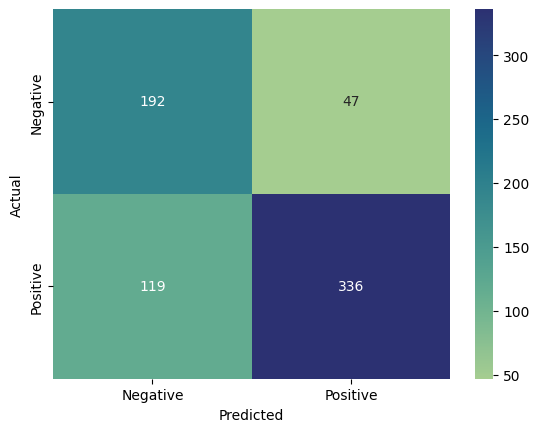

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

nativeBayes = NaiveBayes(modelType="complement")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nativeBayes])

param_grid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [5, 100, 1000]) \
    .addGrid(nativeBayes.smoothing, [0, 1, 2, 4, 8]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

cross_validator = crossval.fit(train)
evaluate_model(cross_validator.transform(test))

Area under PR: 0.871219459279591
Area under ROC: 0.7755942801967906
Accuracy: 0.7435158501440923
Weighted Precision: 0.8003126141586225
Weighted Recall 0.7435158501440922
Weighted F Score 0.749770236931993
Weighted False Positive Rate 0.1923272897505109
Weighted True Positive Rate 0.7435158501440922


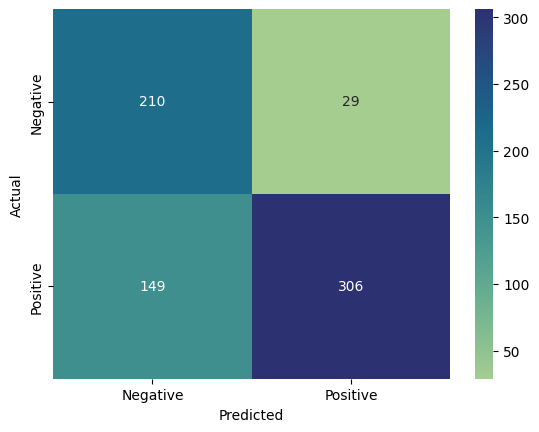

In [11]:
from pyspark.ml.classification import LinearSVC

linSVC = LinearSVC(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, linSVC])

param_grid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [5, 100, 1000]) \
    .addGrid(linSVC.threshold, [0.62, 0.65]) \
    .addGrid(linSVC.regParam, [0.01, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

cross_validator = crossval.fit(train)
evaluate_model(cross_validator.transform(test))
